### Deep Q-Learning

In [50]:
from collections import deque
import random
import gym
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout


class Agent(object):
    
    def __init__(self,learning_rate, discount_rate, epsilon_decay ,memory_length, batch_size, environment):
        #parameter, hyperparameter
        self.state_size = 4
        self.action_size = 2
        self.discount_rate = discount_rate #0.95 #gelecekteki ödüle odaklan ya da elindekiyle yetin
        self.learning_rate = learning_rate #0.001
        self.epsilon = 1 #explore rate - at the beginning explore is maximum
        self.epsilon_decay = epsilon_decay #0.995
        self.epsilon_min = 0.00000001
        self.environment = environment
        self.batch_size = batch_size
        self.memory_length = memory_length
        self.memory = deque(maxlen = self.memory_length) #FIFO data structure
        self.model = self.build_model()
        

     
    def build_model(self):
        # neural network for deep q learning
        model = Sequential()
        model.add(Dense(120, input_dim = self.state_size, activation = "tanh"))
        model.add(Dense(self.action_size,activation = "linear"))
        model.compile(loss = "mse", optimizer = Adam(lr = self.learning_rate))
        return model

            
    def remember(self, state, action, reward, next_state, done):
        #stroge
        memory = (state, action, reward, next_state, done)
        #print("memory : \n", memory,"\n")
        self.memory.append(memory)
        
        
    def act(self,state):
        #explore - select action randomly
        if random.uniform(0,1) <= self.epsilon:
            return self.environment.action_space.sample()
        #exploit
        else:
            actions = self.model.predict(state)
            best_action = np.argmax(actions)
            return best_action
              
    
    def replay(self):
        #training
        if len(self.memory) < self.batch_size:
            return
        #select samples randomly 
        minibatch = random.sample(self.memory,self.batch_size)
        
        loss = []
        
        for state, action, reward, next_state, done in minibatch:
            
            if done:
                target = reward
                
            else:
                target = reward + self.discount_rate*np.amax(self.model.predict(next_state)[0]) 
                

            train_target = self.model.predict(state)
            train_target[0][action] = target
            self.history = self.model.fit(state,train_target, verbose = 0)
            

    
    def adaptiveEpsilonGreedy(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon*self.epsilon_decay
      
    
#********************************************************************************
#MAIN

def trainAgent(episodes, learning_rate, discount_rate, epsilon_decay, memory_length, batch_size, optimization):
    
    #define environment and agent
    environment = gym.make("CartPole-v0")
    
    num_state = environment.observation_space
    num_action = environment.action_space
    
    agent = Agent(learning_rate, discount_rate, epsilon_decay, memory_length, batch_size, environment)
    
    #**************************************ne kadar süre ile exploration yapılacağını ölçüyorum.
    temp_epsilon = agent.epsilon
    i=0
    while(temp_epsilon>agent.epsilon_min):
        temp_epsilon = temp_epsilon*epsilon_decay
        i+=1
    print("{} time step sonunda epsilon {} olacak.".format(i,agent.epsilon_min))
    #****************************************
    time = 0

    time_list = []

    training = True
    
    for i in range(episodes):
        
        #initialize the environment and initial state for every episode
        state = environment.reset()
        state = state.reshape((1,4))
        #print(state.shape)
        
        #**************************************My optimizer************************************************************
        if optimization:
            
            if time == 200:#maximum reward elde edildiği an öğrenmeyi durdur. Çünkü replay memorydeki bilgiler bozabilir.
                training = False
                agent.epsilon = 0 #explorationı durdur
            else:
                training = True
        #**************************************My optimizer************************************************************
        
        
        #time
        time = 0
        
        
        while(True):#time_step         
            #act - select action
            action = agent.act(state)
            
            #apply action and take observations
            next_state, reward, done, _ = environment.step(action)
            next_state = next_state.reshape((1,4))
              
            #remember / storage
            agent.remember(state, action, reward, next_state, done)
    
            #Demonstrate
            #environment.render()
            
            #update state
            state = next_state
            
            #learning
            if training:
                agent.replay()
            
            
            #adjust epsilon
            agent.adaptiveEpsilonGreedy()
            
            #update time
            time = time + 1
            
            #check done
            if done:
                #print("\nEpisode: {} | Time: {}".format(i,time)) 
                time_list.append(time)
                #print("İşlenen toplam time step:",sum(time_list))
                break
                
    print("Training is done.")
    return time_list, agent

### Stop Training Episode Experiment and Optimization

In [60]:
reward1,agent = trainAgent(200, 0.009, 0.95, 0.996, 100, 15, False)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [61]:
reward2,agent = trainAgent(200, 0.009, 0.95, 0.996, 100, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


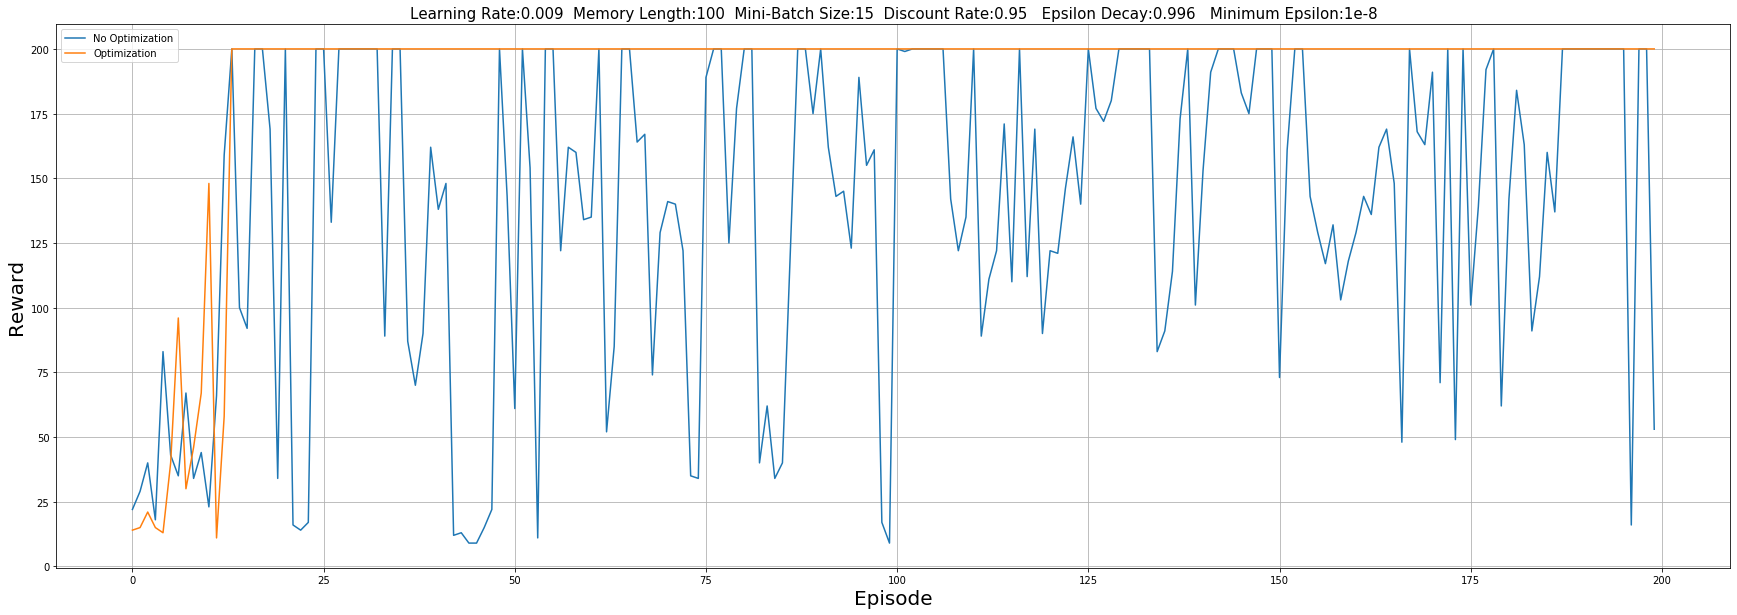

In [62]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(reward1 , label= "No Optimization")
l2, = plt.plot(reward2, label= "Optimization" )

plt.legend(handles=[l1,l2])
plt.xlabel("Episode", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.title("Learning Rate:{}  Memory Length:{}  Mini-Batch Size:{}  Discount Rate:{}   Epsilon Decay:{}   Minimum Epsilon:1e-8".format(agent.learning_rate,agent.memory_length,agent.batch_size,agent.discount_rate,agent.epsilon_decay),fontsize=15)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

### Learning Rate Experiment

In [64]:
reward1,agent = trainAgent(200, 0.001, 0.95, 0.996, 100, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [65]:
reward2,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [66]:
reward3,agent = trainAgent(200, 0.1, 0.95, 0.996, 100, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


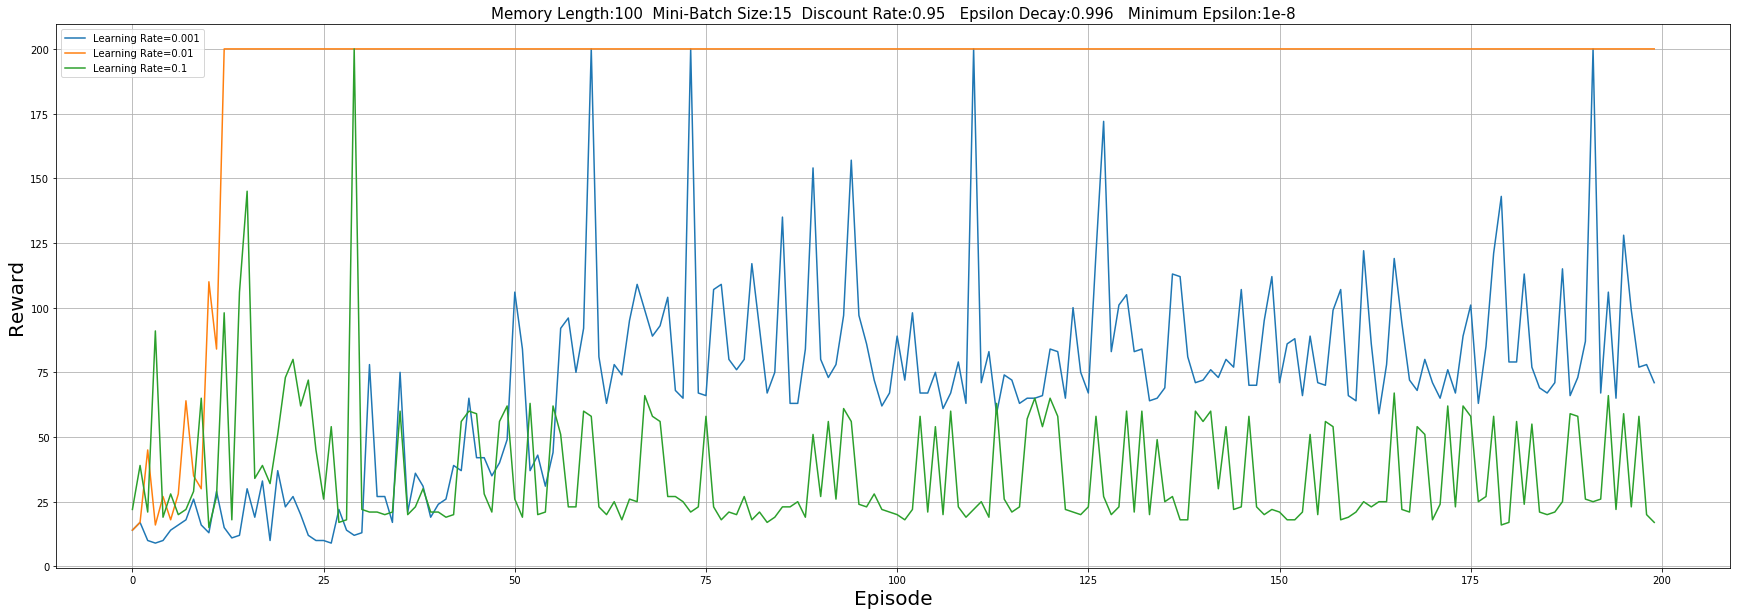

In [67]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(reward1 , label= "Learning Rate=0.001")
l2, = plt.plot(reward2, label= "Learning Rate=0.01" )
l3, = plt.plot(reward3, label= "Learning Rate=0.1" )

plt.legend(handles=[l1,l2,l3])
plt.xlabel("Episode", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.title("Memory Length:{}  Mini-Batch Size:{}  Discount Rate:{}   Epsilon Decay:{}   Minimum Epsilon:1e-8".format(agent.memory_length,agent.batch_size,agent.discount_rate,agent.epsilon_decay),fontsize=15)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

### Mini-Batch Experiment

In [75]:
reward1,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 50, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [76]:
reward2,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [77]:
reward3,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


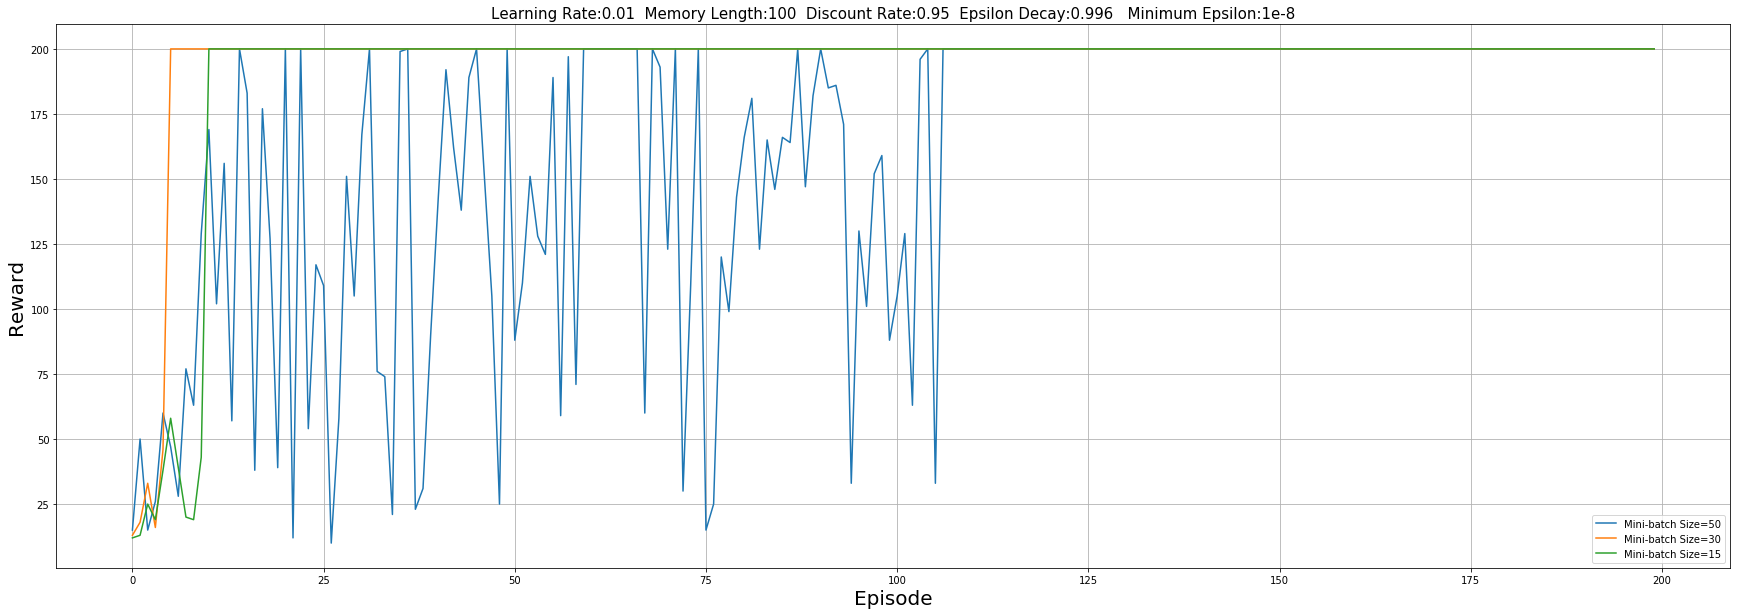

In [78]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(reward1 , label= "Mini-batch Size=50")
l2, = plt.plot(reward2, label= "Mini-batch Size=30" )
l3, = plt.plot(reward3, label= "Mini-batch Size=15" )

plt.legend(handles=[l1,l2,l3])
plt.xlabel("Episode", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.title("Learning Rate:{}  Memory Length:{}  Discount Rate:{}  Epsilon Decay:{}   Minimum Epsilon:1e-8".format(agent.learning_rate,agent.memory_length,agent.discount_rate,agent.epsilon_decay),fontsize=15)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

### Replay Memory Size Experiment

In [2]:
reward1,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

Instructions for updating:
Colocations handled automatically by placer.
4596 time step sonunda epsilon 1e-08 olacak.
Instructions for updating:
Use tf.cast instead.
Training is done.


In [3]:
reward2,agent = trainAgent(200, 0.01, 0.95, 0.996, 200, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [4]:
reward3,agent = trainAgent(200, 0.01, 0.95, 0.996, 300, 15, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


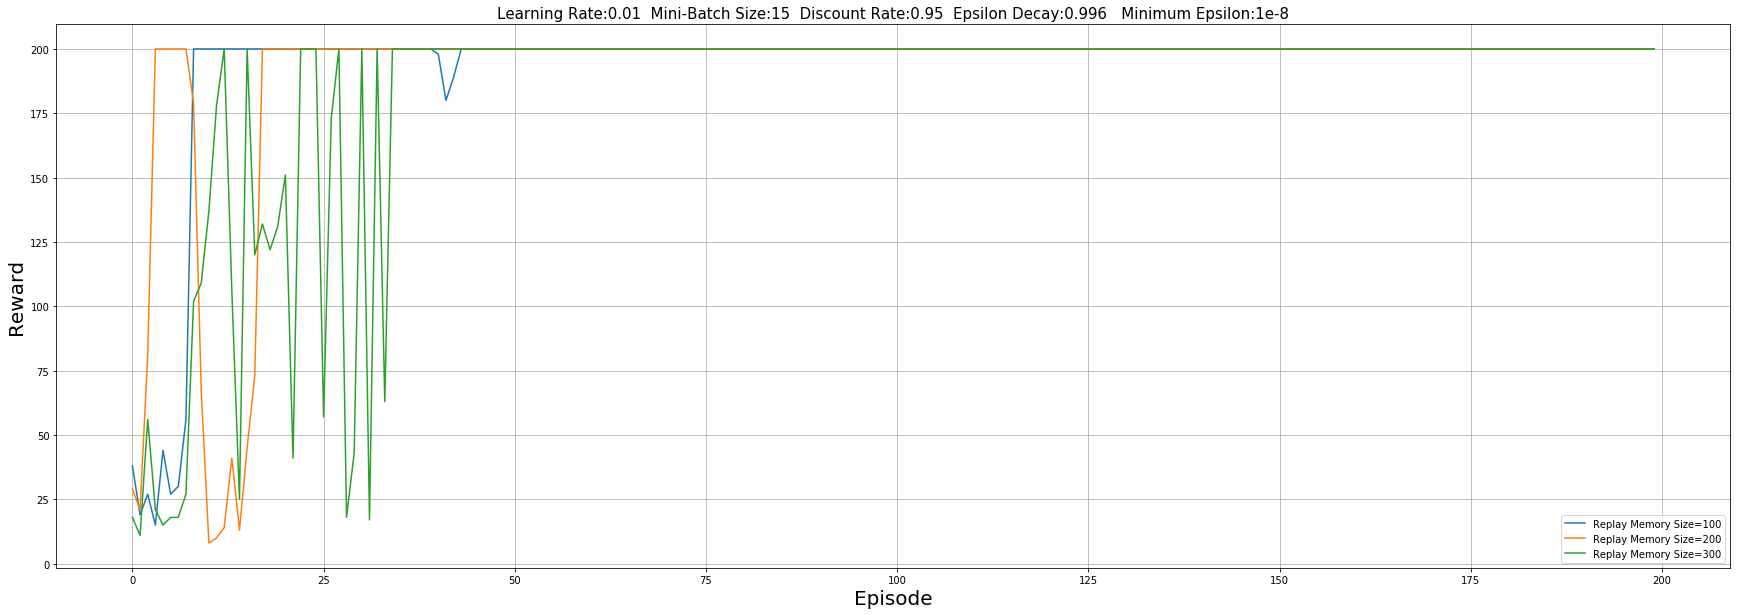

In [8]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(reward1 , label= "Replay Memory Size=100")
l2, = plt.plot(reward2, label= "Replay Memory Size=200" )
l3, = plt.plot(reward3, label= "Replay Memory Size=300" )

plt.legend(handles=[l1,l2,l3])
plt.xlabel("Episode", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.title("Learning Rate:{}  Mini-Batch Size:{}  Discount Rate:{}  Epsilon Decay:{}   Minimum Epsilon:1e-8".format(agent.learning_rate,agent.batch_size,agent.discount_rate,agent.epsilon_decay),fontsize=15)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

### Epislon Decay Experiment

In [10]:
reward1,agent = trainAgent(200, 0.01, 0.95, 0.9, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

175 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [11]:
reward2,agent = trainAgent(200, 0.01, 0.95, 0.7, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

52 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [12]:
reward3,agent = trainAgent(200, 0.01, 0.95, 0.5, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

27 time step sonunda epsilon 1e-08 olacak.
Training is done.


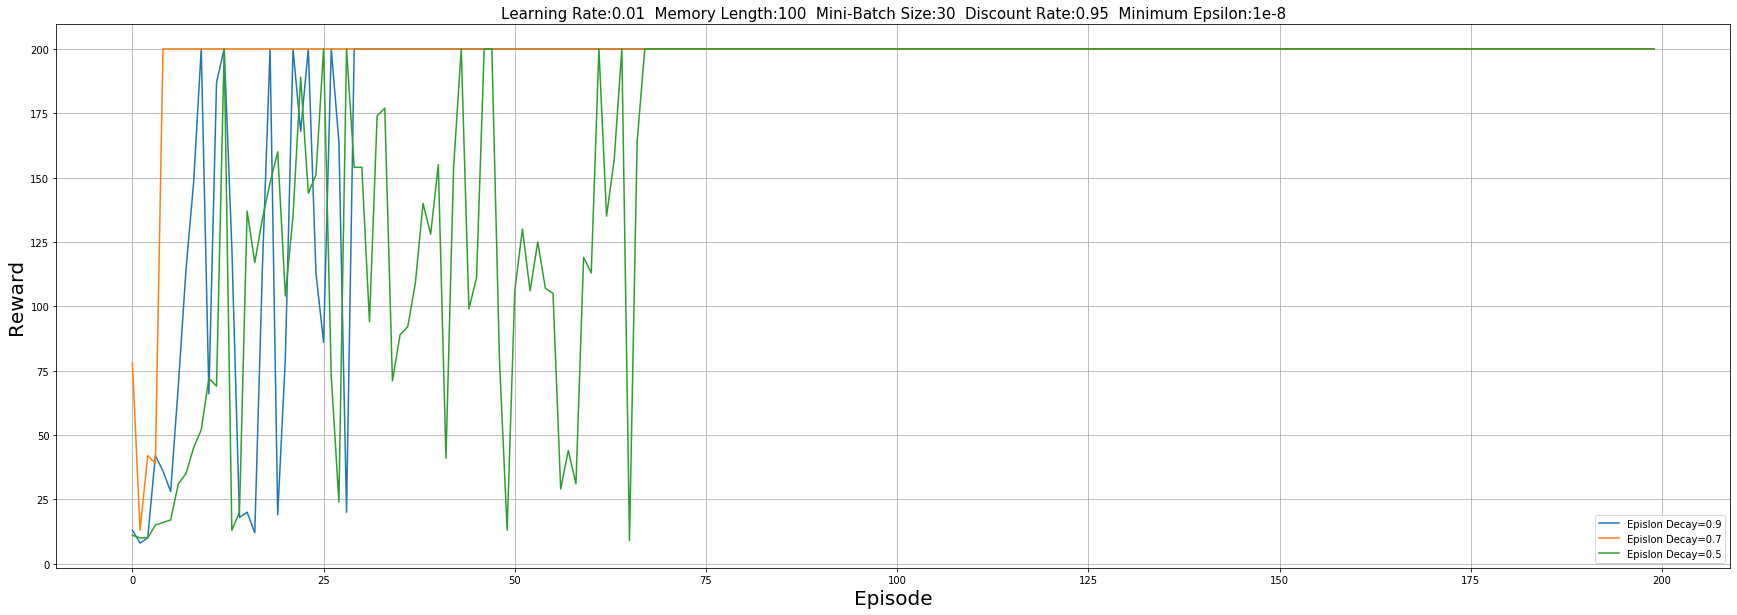

In [13]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(reward1 , label= "Epislon Decay=0.9")
l2, = plt.plot(reward2, label= "Epislon Decay=0.7" )
l3, = plt.plot(reward3, label= "Epislon Decay=0.5" )

plt.legend(handles=[l1,l2,l3])
plt.xlabel("Episode", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.title("Learning Rate:{}  Memory Length:{}  Mini-Batch Size:{}  Discount Rate:{}  Minimum Epsilon:1e-8".format(agent.learning_rate,agent.memory_length,agent.batch_size,agent.discount_rate),fontsize=15)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

### NN Architecture Experiment

#### 1 Hidden Layer with ReLU with 80 nodes

In [25]:
reward1,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


#### 2 Hidden Layer with ReLU with 80 nodes

In [27]:
reward2,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


#### 3 Hidden Layer with ReLU with 80 nodes

In [29]:
reward3,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


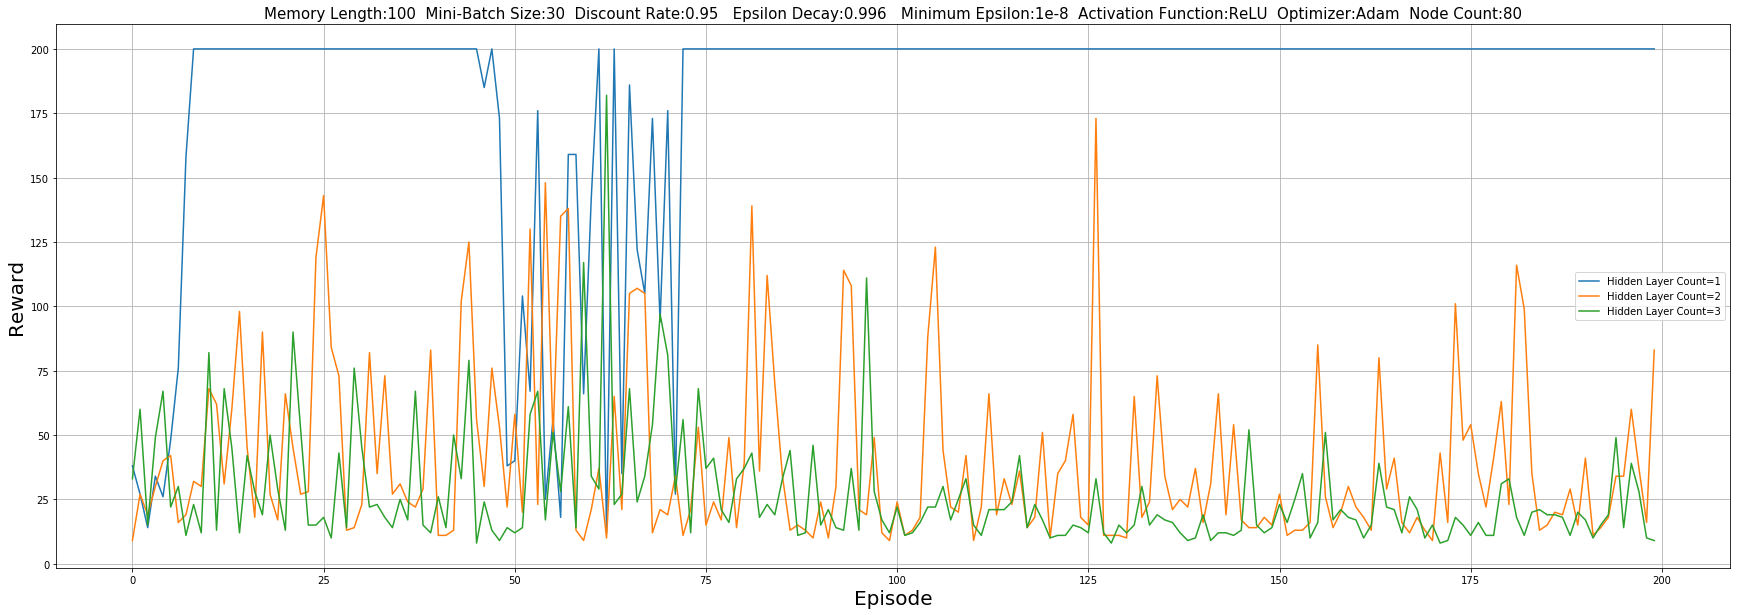

In [30]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(reward1 , label= "Hidden Layer Count=1")
l2, = plt.plot(reward2, label= "Hidden Layer Count=2" )
l3, = plt.plot(reward3, label= "Hidden Layer Count=3" )

plt.legend(handles=[l1,l2,l3])
plt.xlabel("Episode", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.title("Memory Length:{}  Mini-Batch Size:{}  Discount Rate:{}   Epsilon Decay:{}   Minimum Epsilon:1e-8  Activation Function:ReLU  Optimizer:Adam  Node Count:80".format(agent.memory_length,agent.batch_size,agent.discount_rate,agent.epsilon_decay),fontsize=15)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

### Number of Nodes

In [46]:
reward1,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [48]:
reward2,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


In [51]:
reward3,agent = trainAgent(200, 0.01, 0.95, 0.996, 100, 30, True)#episodes,learning_rate,discount_rate,epsilon_decay,memory_length,mini_hatch_size

4596 time step sonunda epsilon 1e-08 olacak.
Training is done.


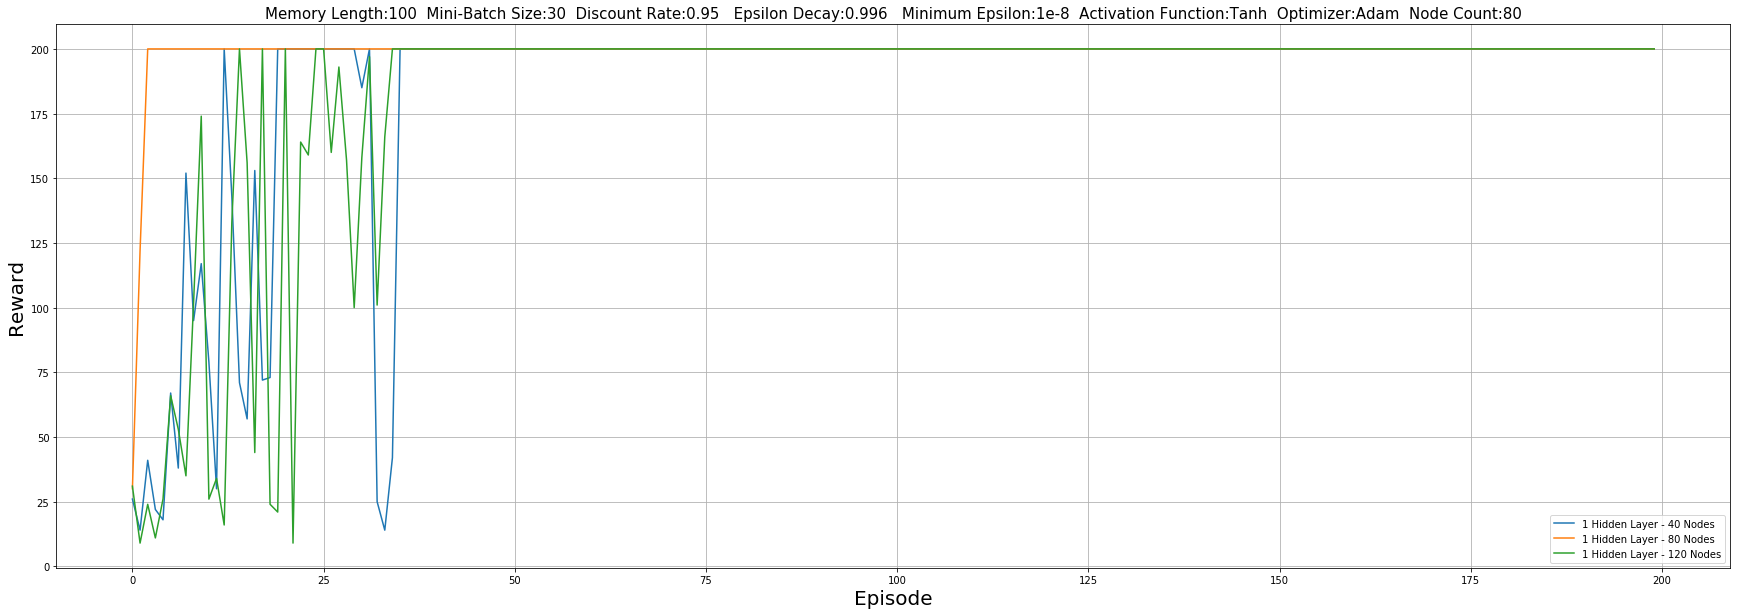

In [53]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(reward1 , label= "1 Hidden Layer - 40 Nodes")
l2, = plt.plot(reward2 , label= "1 Hidden Layer - 80 Nodes")
l3, = plt.plot(reward3 , label= "1 Hidden Layer - 120 Nodes")



plt.legend(handles=[l1,l2,l3])
plt.xlabel("Episode", fontsize=20)
plt.ylabel("Reward", fontsize=20)
plt.title("Memory Length:{}  Mini-Batch Size:{}  Discount Rate:{}   Epsilon Decay:{}   Minimum Epsilon:1e-8  Activation Function:Tanh  Optimizer:Adam  Node Count:80".format(agent.memory_length,agent.batch_size,agent.discount_rate,agent.epsilon_decay),fontsize=15)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()